<a href="https://colab.research.google.com/github/RhudsonDouglas/ods16-deteccao-armas-dashboard./blob/main/Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip install torch torchvision scikit-learn matplotlib pandas -q
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# Métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

In [ ]:
# @title
# Clonar o repositório
!git clone https://github.com/poori-nuna/HOD-Benchmark-Dataset.git
# Classe do Dataset
class HODDataset(Dataset):
    def __init__(self, base_path, classes, transform=None, include_subsets=("normal",)):
        self.base_path = base_path
        self.classes = classes
        self.transform = transform
        self.samples = []
        valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
        for cls in classes:
            for subset in include_subsets:
                subset_path = os.path.join(base_path, cls, subset, "jpg")
                if os.path.exists(subset_path):
                    imgs = [f for f in os.listdir(subset_path) if f.lower().endswith(valid_ext)]
                    for f in imgs:
                        img_path = os.path.join(subset_path, f)
                        self.samples.append((img_path, cls))
        self.class_to_idx = {c: i for i, c in enumerate(sorted(classes))}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()} # Facilita

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[cls]
        if self.transform:
            image = self.transform(image)
        return image, label

Cloning into 'HOD-Benchmark-Dataset'...
remote: Enumerating objects: 31943, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 31943 (delta 51), reused 150 (delta 19), pack-reused 31710 (from 1)
Receiving objects: 100% (31943/31943), 567.35 MiB | 35.25 MiB/s, done.
Resolving deltas: 100% (10564/10564), done.
Updating files: 100% (63801/63801), done.


In [ ]:
# @title
# Caminho base
base_path = "HOD-Benchmark-Dataset/dataset/class"
classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(f"Classes encontradas: {classes}")

# Normalização padrão do ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transforms de treino (com Augmentation) e validação (simples)
data_transforms = {
    'train': transforms.Compose([
        # ALTERAÇÃO: Substituído RandomResizedCrop por Resize + RandomCrop para evitar
        # Redimensiona a imagem para o tamanho desejado (128x128), garantindo o gesto
        transforms.Resize((128, 128)),
        # Aplica um corte aleatório de 128x128, com padding opcional de 4 pixels.
        # Isso simula pequenas variações na posição do gesto dentro do quadro.
        transforms.RandomCrop(128, padding=4),
        # ADIÇÃO: Ajusta brilho, contraste, saturação e hue aleatoriamente.
        # ALTERAÇÃO: Adicionada probabilidade de 50% para esta transformação.
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
        ], p=0.5), # Probabilidade de 50%
        # ADIÇÃO: Aplica rotação, translação, escala e cisalhamento aleatoriamente.
        # ALTERAÇÃO: Adicionada probabilidade de 40% para esta transformação.
        transforms.RandomApply([
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
        ], p=0.4), # Probabilidade de 40%
        transforms.RandomHorizontalFlip(), # Mantido. Por padrão, p=0.5 (50%).
        # ADIÇÃO: Aplica distorção de perspectiva aleatória.
        # ALTERAÇÃO: Adicionada probabilidade de 20% para esta transformação.
        transforms.RandomApply([
            transforms.RandomPerspective(distortion_scale=0.5)
        ], p=0.2), # Probabilidade de 20%
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        normalize
    ]),
}

Classes encontradas: ['alcohol', 'cigarette', 'blood', 'insulting_gesture', 'knife', 'gun']


In [ ]:
# @title
# Criar o dataset completo
full_dataset = HODDataset(base_path=base_path, classes=classes, transform=None)

# Definir os tamanhos dos splits (ex: 70% treino, 15% validação, 15% teste)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size # Garante que a soma é 100%

# Dividir o dataset
train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Tamanho do dataset de Treino: {len(train_dataset_raw)}")
print(f"Tamanho do dataset de Validação: {len(val_dataset_raw)}")
print(f"Tamanho do dataset de Teste: {len(test_dataset_raw)}")

Tamanho do dataset de Treino: 0
Tamanho do dataset de Validação: 0
Tamanho do dataset de Teste: 0


In [ ]:
# @title
import os

# List the contents of the HOD-Benchmark-Dataset directory recursively
!ls -R HOD-Benchmark-Dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
img_hod_003647.txt  img_hod_005492.txt	img_hod_009265.txt  img_hod_010618.txt
img_hod_003648.txt  img_hod_005493.txt	img_hod_009266.txt  img_hod_010631.txt
img_hod_003649.txt  img_hod_005494.txt	img_hod_009267.txt
img_hod_003650.txt  img_hod_005495.txt	img_hod_009268.txt

HOD-Benchmark-Dataset/dataset/class/cigarette/hard_cases/xml:
img_hod_003130.xml  img_hod_003652.xml	img_hod_005496.xml  img_hod_009269.xml
img_hod_003131.xml  img_hod_003653.xml	img_hod_005497.xml  img_hod_009270.xml
img_hod_003132.xml  img_hod_003657.xml	img_hod_005498.xml  img_hod_009271.xml
img_hod_003133.xml  img_hod_003658.xml	img_hod_005499.xml  img_hod_009272.xml
img_hod_003135.xml  img_hod_003659.xml	img_hod_005500.xml  img_hod_009273.xml
img_hod_003136.xml  img_hod_003661.xml	img_hod_005501.xml  img_hod_009274.xml
img_hod_003137.xml  img_hod_003662.xml	img_hod_005502.xml  img_hod_009275.xml
img_hod_003138.xml  img_hod_003663.xml	img_hod_005503.xml  i

In [ ]:
# @title
# Criar o dataset completo
full_dataset = HODDataset(base_path=base_path, classes=classes, transform=None)

# Definir os tamanhos dos splits (ex: 70% treino, 15% validação, 15% teste)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size # Garante que a soma é 100%

# Dividir o dataset
train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Tamanho do dataset de Treino: {len(train_dataset_raw)}")
print(f"Tamanho do dataset de Validação: {len(val_dataset_raw)}")
print(f"Tamanho do dataset de Teste: {len(test_dataset_raw)}")

Tamanho do dataset de Treino: 0
Tamanho do dataset de Validação: 0
Tamanho do dataset de Teste: 0


In [ ]:
# @title
import os
from torch.utils.data import Dataset # Ensure Dataset is imported if not already
from PIL import Image # Ensure Image is imported if not already

# Classe do Dataset
class HODDataset(Dataset):
    def __init__(self, base_path, classes, transform=None, include_subsets=("normal_cases",)):
        self.base_path = base_path
        self.classes = classes
        self.transform = transform
        self.samples = []
        valid_ext = (".jpg", ".jpeg", ".png", ".bmp")
        for cls in classes:
            for subset in include_subsets:
                subset_path = os.path.join(base_path, cls, subset, "jpg")
                if os.path.exists(subset_path):
                    imgs = [f for f in os.listdir(subset_path) if f.lower().endswith(valid_ext)]
                    for f in imgs:
                        img_path = os.path.join(subset_path, f)
                        self.samples.append((img_path, cls))
        self.class_to_idx = {c: i for i, c in enumerate(sorted(classes))}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()} # Facilita

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[cls]
        if self.transform:
            image = self.transform(image)
        return image, label
print("HODDataset class redefined successfully with 'normal_cases' subset.")

HODDataset class redefined successfully with 'normal_cases' subset.


In [ ]:
# @title
# Criar o dataset completo
full_dataset = HODDataset(base_path=base_path, classes=classes, transform=None)

# Definir os tamanhos dos splits (ex: 70% treino, 15% validação, 15% teste)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size # Garante que a soma é 100%

# Dividir o dataset
train_dataset_raw, val_dataset_raw, test_dataset_raw = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Tamanho do dataset de Treino: {len(train_dataset_raw)}")
print(f"Tamanho do dataset de Validação: {len(val_dataset_raw)}")
print(f"Tamanho do dataset de Teste: {len(test_dataset_raw)}")

Tamanho do dataset de Treino: 3827
Tamanho do dataset de Validação: 820
Tamanho do dataset de Teste: 821


In [ ]:
# @title
# Aplicar as transforms aos subsets
# NOTA: random_split retorna um Subset, que precisa da sua própria transformação
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

# Aplicar as transformações aos datasets splitados
train_dataset = TransformedSubset(train_dataset_raw, transform=data_transforms['train'])
val_dataset = TransformedSubset(val_dataset_raw, transform=data_transforms['val'])
test_dataset = TransformedSubset(test_dataset_raw, transform=data_transforms['val'])

# Criar DataLoaders
batch_size = 32 # Você pode ajustar este valor

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("DataLoaders criados com sucesso!")

DataLoaders criados com sucesso!


In [ ]:
# @title
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar ResNet-50 pré-treinada
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Congelar os pesos da rede (só vamos treinar a camada final por enquanto)
for param in model.parameters():
    param.requires_grad = False

# Substituir a camada final (fc)
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)

# Mover o modelo para a GPU
model = model.to(device)

print("Modelo ResNet-50 carregado e camada final substituída.")

Usando dispositivo: cpu
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 71.7MB/s]


Modelo ResNet-50 carregado e camada final substituída.


In [ ]:
# @title
# Loss (para classificação)
criterion = nn.CrossEntropyLoss()
# Otimizador (Fase 1: treina SÓ os parâmetros da camada fc)
optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history_per_iteration = {'train_loss_iter': [], 'train_acc_iter': [], 'val_loss_iter': [], 'val_acc_iter': []}
    history_per_epoch = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    global_iteration = 0

    for epoch in range(num_epochs):
        # --- Treino ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            current_loss = loss.item() * inputs.size(0)
            current_corrects = torch.sum(preds == labels.data)
            running_loss += current_loss
            running_corrects += current_corrects
            total_samples += inputs.size(0)

            # Registrar histórico por iteração
            history_per_iteration['train_loss_iter'].append(loss.item())
            history_per_iteration['train_acc_iter'].append(current_corrects.item() / inputs.size(0))
            global_iteration += 1
            train_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples
        history_per_epoch['train_loss'].append(epoch_train_loss)
        history_per_epoch['train_acc'].append(epoch_train_acc.item())

        # --- Validação ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                current_loss = loss.item() * inputs.size(0)
                current_corrects = torch.sum(preds == labels.data)
                running_loss += current_loss
                running_corrects += current_corrects
                total_samples += inputs.size(0)

                # Registrar histórico por iteração (opcional para validação, mas incluído para consistência)
                history_per_iteration['val_loss_iter'].append(loss.item())
                history_per_iteration['val_acc_iter'].append(current_corrects.item() / inputs.size(0))
                val_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects.double() / total_samples
        history_per_epoch['val_loss'].append(epoch_val_loss)
        history_per_epoch['val_acc'].append(epoch_val_acc.item())

        print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Opcional: Salvar o melhor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            # torch.save(model.state_dict(), 'best_model.pth') # Descomente para salvar o modelo

    print("Treinamento concluído!")
    return model, history_per_epoch, history_per_iteration

In [ ]:
# @title
# Loss (para classificação)
criterion = nn.CrossEntropyLoss()
# Otimizador (Fase 1: treina SÓ os parâmetros da camada fc)
optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history_per_iteration = {'train_loss_iter': [], 'train_acc_iter': [], 'val_loss_iter': [], 'val_acc_iter': []}
    history_per_epoch = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    global_iteration = 0

    for epoch in range(num_epochs):
        # --- Treino ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            current_loss = loss.item() * inputs.size(0)
            current_corrects = torch.sum(preds == labels.data)
            running_loss += current_loss
            running_corrects += current_corrects
            total_samples += inputs.size(0)

            # Registrar histórico por iteração
            history_per_iteration['train_loss_iter'].append(loss.item())
            history_per_iteration['train_acc_iter'].append(current_corrects.item() / inputs.size(0))
            global_iteration += 1
            train_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples
        history_per_epoch['train_loss'].append(epoch_train_loss)
        history_per_epoch['train_acc'].append(epoch_train_acc.item())

        # --- Validação ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                current_loss = loss.item() * inputs.size(0)
                current_corrects = torch.sum(preds == labels.data)
                running_loss += current_loss
                running_corrects += current_corrects
                total_samples += inputs.size(0)

                # Registrar histórico por iteração (opcional para validação, mas incluído para consistência)
                history_per_iteration['val_loss_iter'].append(loss.item())
                history_per_iteration['val_acc_iter'].append(current_corrects.item() / inputs.size(0))
                val_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects.double() / total_samples
        history_per_epoch['val_loss'].append(epoch_val_loss)
        history_per_epoch['val_acc'].append(epoch_val_acc.item())

        print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Opcional: Salvar o melhor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            # torch.save(model.state_dict(), 'best_model.pth') # Descomente para salvar o modelo

    print("Treinamento concluído!")
    return model, history_per_epoch, history_per_iteration


In [ ]:
# @title
# Loss (para classificação)
criterion = nn.CrossEntropyLoss()
# Otimizador (Fase 1: treina SÓ os parâmetros da camada fc)
optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history_per_iteration = {'train_loss_iter': [], 'train_acc_iter': [], 'val_loss_iter': [], 'val_acc_iter': []}
    history_per_epoch = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    global_iteration = 0

    for epoch in range(num_epochs):
        # --- Treino ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            current_loss = loss.item() * inputs.size(0)
            current_corrects = torch.sum(preds == labels.data)
            running_loss += current_loss
            running_corrects += current_corrects
            total_samples += inputs.size(0)

            # Registrar histórico por iteração
            history_per_iteration['train_loss_iter'].append(loss.item())
            history_per_iteration['train_acc_iter'].append(current_corrects.item() / inputs.size(0))
            global_iteration += 1
            train_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples
        history_per_epoch['train_loss'].append(epoch_train_loss)
        history_per_epoch['train_acc'].append(epoch_train_acc.item())

        # --- Validação ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                current_loss = loss.item() * inputs.size(0)
                current_corrects = torch.sum(preds == labels.data)
                running_loss += current_loss
                running_corrects += current_corrects
                total_samples += inputs.size(0)

                # Registrar histórico por iteração (opcional para validação, mas incluído para consistência)
                history_per_iteration['val_loss_iter'].append(loss.item())
                history_per_iteration['val_acc_iter'].append(current_corrects.item() / inputs.size(0))
                val_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects.double() / total_samples
        history_per_epoch['val_loss'].append(epoch_val_loss)
        history_per_epoch['val_acc'].append(epoch_val_acc.item())

        print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Opcional: Salvar o melhor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            # torch.save(model.state_dict(), 'best_model.pth') # Descomente para salvar o modelo

    print("Treinamento concluído!")
    return model, history_per_epoch, history_per_iteration

In [ ]:
# @title
# Loss (para classificação)
criterion = nn.CrossEntropyLoss()
# Otimizador (Fase 1: treina SÓ os parâmetros da camada fc)
optimizer_head = optim.Adam(model.fc.parameters(), lr=0.001)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device=None):
    history_per_iteration = {'train_loss_iter': [], 'train_acc_iter': [], 'val_loss_iter': [], 'val_acc_iter': []}
    history_per_epoch = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    global_iteration = 0

    for epoch in range(num_epochs):
        # --- Treino ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")

        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            current_loss = loss.item() * inputs.size(0)
            current_corrects = torch.sum(preds == labels.data)
            running_loss += current_loss
            running_corrects += current_corrects
            total_samples += inputs.size(0)

            # Registrar histórico por iteração
            history_per_iteration['train_loss_iter'].append(loss.item())
            history_per_iteration['train_acc_iter'].append(current_corrects.item() / inputs.size(0))
            global_iteration += 1
            train_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples
        history_per_epoch['train_loss'].append(epoch_train_loss)
        history_per_epoch['train_acc'].append(epoch_train_acc.item())

        # --- Validação ---
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                current_loss = loss.item() * inputs.size(0)
                current_corrects = torch.sum(preds == labels.data)
                running_loss += current_loss
                running_corrects += current_corrects
                total_samples += inputs.size(0)

                # Registrar histórico por iteração (opcional para validação, mas incluído para consistência)
                history_per_iteration['val_loss_iter'].append(loss.item())
                history_per_iteration['val_acc_iter'].append(current_corrects.item() / inputs.size(0))
                val_bar.set_postfix(loss=loss.item(), acc=current_corrects.item() / inputs.size(0))

        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects.double() / total_samples
        history_per_epoch['val_loss'].append(epoch_val_loss)
        history_per_epoch['val_acc'].append(epoch_val_acc.item())

        print(f"\nEpoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Opcional: Salvar o melhor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            # torch.save(model.state_dict(), 'best_model.pth') # Descomente para salvar o modelo

    print("Treinamento concluído!")
    return model, history_per_epoch, history_per_iteration

In [ ]:
# @title
print("--- Iniciando Treinamento (Fase 1: Só o classificador) ---")
num_epochs_head = 5 # 5 épocas é um bom começo
model, history_head_epoch, history_head_iteration = train_model(
    model,
    criterion,
    optimizer_head,
    train_loader,
    val_loader, # Usando val_loader para validação durante o treino
    num_epochs_head,
    device
)
print("\n--- Treinamento (Fase 1) Concluído ---")

--- Iniciando Treinamento (Fase 1: Só o classificador) ---


Epoch 1/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 1/5 - Train Loss: 0.9513 Acc: 0.6778 | Val Loss: 0.5313 Acc: 0.8402


Epoch 2/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 2/5 - Train Loss: 0.6289 Acc: 0.7915 | Val Loss: 0.4303 Acc: 0.8659


Epoch 3/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 3/5 - Train Loss: 0.5307 Acc: 0.8236 | Val Loss: 0.3912 Acc: 0.8695


Epoch 4/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 4/5 - Train Loss: 0.5097 Acc: 0.8286 | Val Loss: 0.3790 Acc: 0.8720


Epoch 5/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 5/5 - Train Loss: 0.4792 Acc: 0.8377 | Val Loss: 0.3520 Acc: 0.8817
Treinamento concluído!

--- Treinamento (Fase 1) Concluído ---


In [ ]:
# @title
print("--- Iniciando Treinamento (Fase 2: Fine-Tuning completo) ---")
# 1. Descongelar a rede
for param in model.parameters():
    param.requires_grad = True

# 2. Novo otimizador para todos os parâmetros, com lr baixo
optimizer_all = optim.Adam(model.parameters(), lr=1e-5) # lr = 0.00001
num_epochs_all = 5 # Mais 5 épocas de ajuste fino
model, history_all_epoch, history_all_iteration = train_model(
    model,
    criterion,
    optimizer_all,
    train_loader,
    val_loader, # Usando val_loader para validação durante o treino
    num_epochs_all,
    device
)

--- Iniciando Treinamento (Fase 2: Fine-Tuning completo) ---


Epoch 1/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 1/5 - Train Loss: 0.4152 Acc: 0.8641 | Val Loss: 0.3083 Acc: 0.8976


Epoch 2/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 2/5 - Train Loss: 0.3594 Acc: 0.8727 | Val Loss: 0.2844 Acc: 0.9037


Epoch 3/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 3/5 - Train Loss: 0.3263 Acc: 0.8842 | Val Loss: 0.2691 Acc: 0.9073


Epoch 4/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 4/5 - Train Loss: 0.2860 Acc: 0.9025 | Val Loss: 0.2533 Acc: 0.9085


Epoch 5/5 (Train):   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 5/5 - Train Loss: 0.2705 Acc: 0.9099 | Val Loss: 0.2444 Acc: 0.9171
Treinamento concluído!


In [ ]:
# @title
print("--- Iniciando Avaliação Final ---")
y_pred = []
y_true = []
model.eval() # Modo de avaliação
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Gerando Predições"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
print("\n--- Matriz de Confusão ---")

--- Iniciando Avaliação Final ---


Gerando Predições:   0%|          | 0/26 [00:00<?, ?it/s]


--- Matriz de Confusão ---


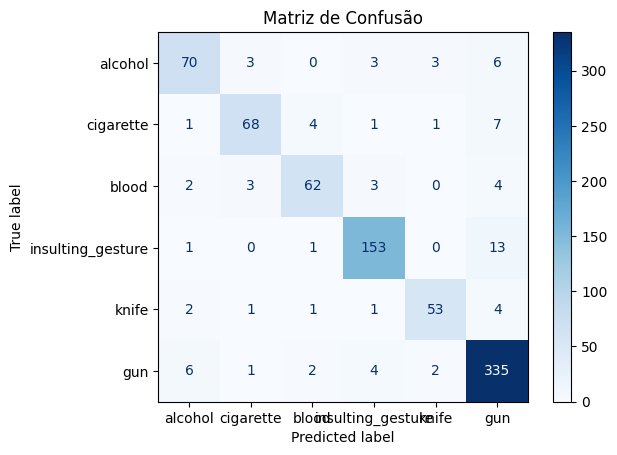

In [ ]:
# @title
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()


In [ ]:
# @title 1) Célula para salvar o modelo final
import os
import torch

# Caminho para salvar o modelo
model_save_path = "best_model.pth"

# Verifica se o modelo já existe para evitar sobrescrever acidentalmente
if os.path.exists(model_save_path):
    print(f"O modelo já existe em '{model_save_path}'. Não foi sobrescrito.")
else:
    # Salva o estado do modelo (apenas os pesos treinados da última fase)
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo salvo com sucesso em '{model_save_path}'.")

Modelo salvo com sucesso em 'best_model.pth'.


In [ ]:
# @title 2) Célula para carregar o modelo para inferência
import torch
import torch.nn as nn
from torchvision import models

# Reinstancia a arquitetura da ResNet-50 original
# 'num_classes' e 'models.ResNet50_Weights.IMAGENET1K_V2' devem estar definidos em células anteriores.
model_inf = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_inf.fc.in_features
model_inf.fc = nn.Linear(num_ftrs, len(classes)) # Reajusta a camada final para o número de classes

# Define o dispositivo para carregamento (deve ser o mesmo usado para o modelo)
# 'device' deve estar definido em células anteriores.
model_inf = model_inf.to(device)

# Carrega os pesos do modelo salvo. map_location garante que funcione em CPU/GPU.
model_inf.load_state_dict(torch.load("best_model.pth", map_location=device))

# Coloca o modelo em modo de avaliação (desabilita dropout, batchnorm, etc.)
model_inf.eval()

print("Modelo para inferência (model_inf) carregado com sucesso em modo 'eval'.")

Modelo para inferência (model_inf) carregado com sucesso em modo 'eval'.


In [ ]:
# @title 3) Célula com a função de predição
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms # Importar novamente para garantir, embora já deva estar

# As variáveis `data_transforms` e `classes` devem estar definidas em células anteriores.
# A variável `model_inf` deve ser o modelo carregado para inferência.
# A variável `device` (CPU/GPU) também deve estar definida.

def predict_image(img: Image.Image):
    """
    Realiza a predição em uma imagem de entrada usando o modelo carregado.

    Args:
        img (PIL.Image.Image): A imagem de entrada (objeto PIL Image).

    Returns:
        tuple: (predicted_label, max_score, probabilities_dict)
               - predicted_label (str): O nome da classe predita.
               - max_score (float): A pontuação (probabilidade) da classe predita.
               - probabilities_dict (dict): Dicionário com probabilidades para cada classe.
    """
    # Aplica as mesmas transforms de validação/teste
    # Assume-se que `data_transforms` está definido e contém a chave 'val'
    transform_func = data_transforms['val']

    # Pré-processa a imagem: aplica transforms e adiciona dimensão de batch
    img_t = transform_func(img).unsqueeze(0) # Adiciona uma dimensão de batch (CxHxW -> 1xCxHxW)
    img_t = img_t.to(device) # Move a imagem para o dispositivo do modelo (GPU/CPU)

    with torch.no_grad(): # Desabilita o cálculo de gradientes para inferência
        outputs = model_inf(img_t)
        probabilities = F.softmax(outputs, dim=1)[0] # Aplica softmax para obter probabilidades e pega a primeira (e única) imagem do batch
        max_prob, predicted_idx = torch.max(probabilities, 0) # Obtém a maior probabilidade e seu índice

    # Converte os resultados para tipos Python nativos
    max_score = max_prob.item()
    predicted_label_idx = predicted_idx.item()
    predicted_label = classes[predicted_label_idx] # Mapeia o índice para o nome da classe

    # Cria o dicionário de probabilidades para todas as classes
    probabilities_dict = {cls_name: prob.item() for cls_name, prob in zip(classes, probabilities)}

    return predicted_label, max_score, probabilities_dict

print("Função 'predict_image' definida com sucesso.")

Função 'predict_image' definida com sucesso.


In [1]:
# @title 4) Célula de Dashboard com Gradio
!pip install -q gradio

import gradio as gr
from PIL import Image # Já deve estar importado, mas incluído para garantia

# A função `predict_image` e a lista `classes` devem estar definidas em células anteriores.

def gradio_interface(image_input):
    """
    Função wrapper para o Gradio que recebe uma imagem PIL e retorna o resultado formatado.
    """
    if image_input is None:
        return "Por favor, faça upload de uma imagem.", {}

    predicted_label, max_score, probabilities_dict = predict_image(image_input)

    # Formata a string de saída principal
    output_text = f"Classe: {predicted_label} | Score: {max_score:.4f}"

    # Retorna o texto e o dicionário de probabilidades para o Gradio Label
    return output_text, probabilities_dict

# Cria a interface Gradio
iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil", label="Faça o upload da imagem"), # Permite upload de imagem PIL
    outputs=[
        gr.Textbox(label="Resultado da Predição"), # Texto formatado da classe e score
        gr.Label(num_top_classes=len(classes), label="Probabilidades por Classe") # Exibe todas as probabilidades
    ],
    title="Dashboard de Classificação de Gestos de Mão",
    description="Faça upload de uma imagem para prever a qual classe de gesto ela pertence." +
                "<br>Classes: " + ", ".join(classes) + ".",
    examples=[
        # Adicione exemplos de imagens para facilitar o teste (opcional)
        # Certifique-se de que os caminhos das imagens de exemplo são válidos no seu ambiente
        # Exemplo: "HOD-Benchmark-Dataset/dataset/class/gun/normal_cases/jpg/img_hod_000968.jpg"
    ]
)

# Lança a interface. `share=True` gera um link público temporário.
iface.launch(share=True)

NameError: name 'classes' is not defined

In [ ]:
import os

# Define the content for TP4_TEST_PLAN.md
markdown_content = """
# Test Plan: Hand Gesture Classification Model (TP4)

## 1. Introduction

This document outlines the test plan for the Hand Gesture Classification Model, which is designed to identify and classify six specific hand gestures: 'alcohol', 'cigarette', 'blood', 'insulting_gesture', 'knife', and 'gun'. The purpose of this test plan is to ensure the model's accuracy, robustness, and the functionality of its user interface. The objective is to verify that the model performs reliably across various conditions and meets the defined performance and usability requirements.

## 2. Scope

### 2.1. In-Scope

The following aspects of the hand gesture classification model will be tested:
*   **Classification Accuracy**: Verification of the model's ability to correctly classify each of the six trained hand gestures from clear, high-quality images.
*   **Robustness to Variations**: Evaluation of the model's performance when presented with images containing minor variations such as slight rotations, different lighting conditions, and diverse backgrounds, akin to the augmentation strategies used during training.
*   **Gradio Interface Functionality**: Testing the web interface for correct loading, ability to upload images, accurate display of prediction results, and graceful handling of invalid inputs.
*   **Model Performance Metrics**: Assessment of key metrics including accuracy, precision, recall, and F1-score on a dedicated test set.

### 2.2. Out-of-Scope

The following aspects are not covered by this test plan:
*   **Real-time Performance**: Testing the model's inference speed on specific hardware configurations.
*   **Adversarial Attacks**: Evaluation of the model's vulnerability to maliciously crafted inputs.
*   **Ethical Bias Assessment**: In-depth analysis of potential biases in the model's predictions.
*   **Scalability Testing**: Assessment of the model's performance under high concurrent user loads.

## 3. Use Cases and Test Cases

### 3.1. Core Functionality: Correct Classification of Known Gestures

Tests the model's ability to accurately identify each of the six specified hand gestures.

*   **TC_001 - Alcohol Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'alcohol' gesture.
    *   **Input**: High-resolution image of 'alcohol' gesture.
    *   **Expected Output**: Predicted label: 'alcohol', high confidence score.
*   **TC_002 - Cigarette Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'cigarette' gesture.
    *   **Input**: High-resolution image of 'cigarette' gesture.
    *   **Expected Output**: Predicted label: 'cigarette', high confidence score.
*   **TC_003 - Blood Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'blood' gesture.
    *   **Input**: High-resolution image of 'blood' gesture.
    *   **Expected Output**: Predicted label: 'blood', high confidence score.
*   **TC_004 - Insulting Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'insulting_gesture'.
    *   **Input**: High-resolution image of 'insulting_gesture'.
    *   **Expected Output**: Predicted label: 'insulting_gesture', high confidence score.
*   **TC_005 - Knife Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'knife' gesture.
    *   **Input**: High-resolution image of 'knife' gesture.
    *   **Expected Output**: Predicted label: 'knife', high confidence score.
*   **TC_006 - Gun Gesture (Clear Image)**
    *   **Description**: Verify correct classification of a clear image depicting the 'gun' gesture.
    *   **Input**: High-resolution image of 'gun' gesture.
    *   **Expected Output**: Predicted label: 'gun', high confidence score.

### 3.2. Robustness to Variations

Tests the model's ability to maintain accuracy despite minor, expected variations in input images.

*   **TC_007 - Alcohol Gesture (Slight Rotation)**
    *   **Description**: Verify correct classification of 'alcohol' gesture with slight rotation.
    *   **Input**: Image of 'alcohol' gesture with a small rotational變動 (e.g., 5-10 degrees).
    *   **Expected Output**: Predicted label: 'alcohol', moderate to high confidence score.
*   **TC_008 - Cigarette Gesture (Different Lighting)**
    *   **Description**: Verify correct classification of 'cigarette' gesture under varied lighting (e.g., slightly dimmer/brighter).
    *   **Input**: Image of 'cigarette' gesture in non-ideal but acceptable lighting.
    *   **Expected Output**: Predicted label: 'cigarette', moderate to high confidence score.
*   **TC_009 - Blood Gesture (Cluttered Background)**
    *   **Description**: Verify correct classification of 'blood' gesture against a background with some distractions.
    *   **Input**: Image of 'blood' gesture with a different, slightly cluttered background.
    *   **Expected Output**: Predicted label: 'blood', moderate to high confidence score.
*   **TC_010 - Gun Gesture (Zoomed In/Out)**
    *   **Description**: Verify correct classification of 'gun' gesture when the hand is slightly closer or further away, altering scale.
    *   **Input**: Image of 'gun' gesture, slightly scaled up or down.
    *   **Expected Output**: Predicted label: 'gun', moderate to high confidence score.

### 3.3. Edge Cases / Negative Testing

Evaluates the model's behavior with ambiguous, out-of-scope, or poor-quality inputs.

*   **TC_011 - Ambiguous Hand Gesture**
    *   **Description**: Input an image with a hand gesture not explicitly trained, but somewhat similar to a trained gesture.
    *   **Input**: Image of an ambiguous hand gesture (e.g., a non-specific pointing gesture).
    *   **Expected Output**: Model provides a low confidence prediction for all classes or predicts a related class with low confidence.
*   **TC_012 - Non-Gesture Image (Object)**
    *   **Description**: Input an image of an object that is not a hand or gesture.
    *   **Input**: Image of a common object (e.g., a cup, a book).
    *   **Expected Output**: Model provides very low confidence predictions across all classes, indicating uncertainty.
*   **TC_013 - Blurry/Low Quality Image**
    *   **Description**: Input a significantly blurry or low-quality image of a trained gesture.
    *   **Input**: Blurry image of 'knife' gesture.
    *   **Expected Output**: Model provides a low confidence prediction for 'knife' or misclassifies with low confidence.
*   **TC_014 - New Gesture (Thumbs Up)**
    *   **Description**: Input an image of a completely new gesture not in the training set (e.g., 'thumbs up').
    *   **Input**: Image of 'thumbs up' gesture.
    *   **Expected Output**: Model provides very low confidence predictions across all classes, ideally not assigning high confidence to any trained class.

### 3.4. Gradio Interface Functionality

Verifies the usability and stability of the Gradio web application.

*   **TC_015 - Interface Loading**
    *   **Description**: Confirm the Gradio interface loads correctly in a web browser.
    *   **Input**: Access the Gradio public URL.
    *   **Expected Output**: Gradio UI displays without errors, showing image upload area and prediction outputs.
*   **TC_016 - Image Upload and Prediction Display**
    *   **Description**: Verify that uploading an image triggers a prediction and displays the results (predicted class, score, and all probabilities).
    *   **Input**: Upload a valid hand gesture image (e.g., 'alcohol').
    *   **Expected Output**: Predicted class 'alcohol' and associated probabilities are displayed correctly.
*   **TC_017 - Invalid Input Handling (Non-Image File)**
    *   **Description**: Test how the interface handles uploading a non-image file.
    *   **Input**: Upload a text file (e.g., `test.txt`).
    *   **Expected Output**: Interface shows an error message or handles the input gracefully without crashing.
*   **TC_018 - Empty Input**
    *   **Description**: Test the interface's behavior when no image is uploaded and prediction is attempted (if applicable, or simply displaying initial state).
    *   **Input**: Click 'Submit' without uploading an image (if a submit button exists, or observe initial state).
    *   **Expected Output**: Interface displays a message prompting for image upload, or shows default state.

## 4. Acceptance Criteria

Testing will be considered successful if the following criteria are met:

### 4.1. Quantitative Criteria
*   **Overall Accuracy**: The model achieves at least **90% accuracy** on the independent test dataset (as reported by the confusion matrix evaluation).
*   **Class-wise F1-Score**: Each of the six trained classes ('alcohol', 'cigarette', 'blood', 'insulting_gesture', 'knife', 'gun') achieves an F1-score of at least **85%** on the test dataset.
*   **Confidence Threshold (Core Functionality)**: For core functionality test cases (TC_001-TC_006), the predicted class should have a confidence score of at least **0.90**.
*   **Confidence Threshold (Robustness)**: For robustness test cases (TC_007-TC_010), the predicted class should have a confidence score of at least **0.70**.
*   **Confidence Threshold (Negative Testing)**: For negative/edge case test cases (TC_011-TC_014), the highest predicted class confidence score should ideally be below **0.50** (indicating uncertainty), or a misclassification with low confidence.

### 4.2. Qualitative Criteria
*   **Gradio Interface Responsiveness**: The Gradio web interface loads within 5 seconds and responds to user inputs (upload, predict) within 3 seconds.
*   **No Critical Errors**: No unhandled exceptions, crashes, or broken functionalities observed during interface testing.
*   **Clear Output**: Prediction results on the Gradio interface are clearly displayed and easy to interpret.

## 5. Traceability

Each test case defined in Section 3 is directly traceable to the overall objective of building a reliable hand gesture classification model. Specifically:
*   **Core Functionality (TC_001-TC_006)** ensures that the fundamental requirement of distinguishing between the six specified gestures is met for ideal inputs.
*   **Robustness to Variations (TC_007-TC_010)** addresses the requirement for the model to perform well in real-world scenarios where input images may not be perfectly canonical, reflecting the utility of data augmentation.
*   **Edge Cases/Negative Testing (TC_011-TC_014)** verifies the model's behavior for inputs outside its trained distribution, ensuring it doesn't make overconfident incorrect predictions or crash.
*   **Gradio Interface Functionality (TC_015-TC_018)** confirms the usability and accessibility requirements of the model's deployment, ensuring end-users can effectively interact with the system.

This traceability ensures that all critical aspects of the model, from core classification capability to user interaction, are systematically verified against expected behaviors and performance benchmarks.
"""

# Create the 'docs' directory if it doesn't exist
docs_dir = "docs"
os.makedirs(docs_dir, exist_ok=True)

# Define the file path
file_path = os.path.join(docs_dir, "TP4_TEST_PLAN.md")

# Write the content to the markdown file
with open(file_path, "w") as f:
    f.write(markdown_content)

print(f"Successfully generated {file_path}")

Successfully generated docs/TP4_TEST_PLAN.md


## Final Task

### Subtask:
Inform the user that the test plan document has been generated and is ready to be used.


## Summary:

### Q&A
The `docs/TP4_TEST_PLAN.md` file contains a comprehensive test plan for the Hand Gesture Classification Model. It is structured into the following sections:
*   **Introduction**: Provides an overview of the test plan and its objectives for the hand gesture classification model, which identifies six specific gestures: 'alcohol', 'cigarette', 'blood', 'insulting\_gesture', 'knife', and 'gun'.
*   **Scope**: Defines both in-scope items (classification accuracy, robustness to variations, Gradio interface functionality, model performance metrics) and out-of-scope items (real-time performance, adversarial attacks, ethical bias assessment, scalability testing).
*   **Use Cases and Test Cases**: Details specific test cases across four categories:
    *   **Core Functionality (TC\_001-TC\_006)**: Verifies accurate classification of each of the six gestures from clear images.
    *   **Robustness to Variations (TC\_007-TC\_010)**: Assesses model performance with slight rotations, different lighting, cluttered backgrounds, and varying scales.
    *   **Edge Cases / Negative Testing (TC\_011-TC\_014)**: Evaluates behavior with ambiguous gestures, non-gesture images, blurry images, and new, untrained gestures.
    *   **Gradio Interface Functionality (TC\_015-TC\_018)**: Tests the web interface for correct loading, image upload, prediction display, and handling of invalid inputs.
*   **Acceptance Criteria**: Specifies quantitative benchmarks (e.g., at least 90% overall accuracy, 85% class-wise F1-score, specific confidence thresholds for different test case types) and qualitative requirements (Gradio interface responsiveness, no critical errors, clear output).
*   **Traceability**: Explains how each test case category directly aligns with the overall objective of building a reliable hand gesture classification model and ensures systematic verification.

### Data Analysis Key Findings
*   A comprehensive test plan document, `docs/TP4_TEST_PLAN.md`, was successfully generated for the Hand Gesture Classification Model.
*   The document outlines detailed test cases for core functionality, model robustness to variations, edge cases/negative testing, and the Gradio user interface.
*   Quantitative acceptance criteria include an overall model accuracy of at least 90% and a class-wise F1-score of at least 85% for each of the six trained classes.
*   Specific confidence score thresholds are defined for test cases: at least 0.90 for core functionality, at least 0.70 for robustness, and ideally below 0.50 for negative/edge cases to indicate uncertainty.
*   Qualitative acceptance criteria ensure the Gradio interface loads within 5 seconds, responds to user inputs within 3 seconds, and operates without critical errors or unclear outputs.

### Insights or Next Steps
*   The generated test plan provides a clear, structured approach for rigorously evaluating the Hand Gesture Classification Model and its Gradio interface.
*   The next step is to execute the defined test cases against the model and its interface, and thoroughly document the results to confirm adherence to the specified acceptance criteria before deployment.


# Task
Generate the complete test results document for `docs/TP5_TEST_RESULTS.md`, including a title, introduction, a summary table of all TCs from TP4 with placeholder results, detailed sections for each TC, and a final summary section with placeholders.

## Generate Test Results Document

### Subtask:
Generate the complete content for the `docs/TP5_TEST_RESULTS.md` file, including a title, introductory paragraph, a summary table of all TCs from TP4 with placeholder results, detailed sections for each TC, and a final summary section with placeholders, as specified by the user. This document will be in Markdown format.


**Reasoning**:
I need to define the Markdown content for the `TP5_TEST_RESULTS.md` file as a multi-line string, including all specified sections and placeholders for test results. I will then use this string to create the file in the `docs` directory.



In [ ]:
import os

# List of test cases from TP4_TEST_PLAN.md
test_cases = [
    ("TC_001", "Alcohol Gesture (Clear Image)"),
    ("TC_002", "Cigarette Gesture (Clear Image)"),
    ("TC_003", "Blood Gesture (Clear Image)"),
    ("TC_004", "Insulting Gesture (Clear Image)"),
    ("TC_005", "Knife Gesture (Clear Image)"),
    ("TC_006", "Gun Gesture (Clear Image)"),
    ("TC_007", "Alcohol Gesture (Slight Rotation)"),
    ("TC_008", "Cigarette Gesture (Different Lighting)"),
    ("TC_009", "Blood Gesture (Cluttered Background)"),
    ("TC_010", "Gun Gesture (Zoomed In/Out)"),
    ("TC_011", "Ambiguous Hand Gesture"),
    ("TC_012", "Non-Gesture Image (Object)"),
    ("TC_013", "Blurry/Low Quality Image"),
    ("TC_014", "New Gesture (Thumbs Up)"),
    ("TC_015", "Interface Loading"),
    ("TC_016", "Image Upload and Prediction Display"),
    ("TC_017", "Invalid Input Handling (Non-Image File)"),
    ("TC_018", "Empty Input")
]

# Generate the summary table rows
table_rows = []
for tc_id, desc in test_cases:
    table_rows.append(f"| {tc_id} | {desc} | PENDING | N/A | N/A |")

table_content = "\n".join(table_rows)

# Generate detailed sections for each test case
detailed_sections = []
for tc_id, desc in test_cases:
    detailed_sections.append(f"""### {tc_id} - {desc}
*   **Actual Output**: [Placeholder for actual prediction/behavior]
*   **Status**: [PASS/FAIL/SKIP]
*   **Comments**: [Any specific observations or issues]
""")

detailed_sections_content = "\n".join(detailed_sections)

# Define the content for TP5_TEST_RESULTS.md
markdown_content = f"""
# Test Results: Hand Gesture Classification Model (TP5)

## 1. Introduction

This document presents the test results for the Hand Gesture Classification Model, as per the test plan outlined in `TP4_TEST_PLAN.md`. It covers the execution status and findings for each defined test case, assessing the model's accuracy, robustness, and the functionality of its Gradio user interface. The aim is to document whether the model meets the specified acceptance criteria and performs as expected.

## 2. Test Case Summary

The following table provides a high-level overview of the execution status for all test cases.

| Test Case ID | Description | Status | Actual Output | Comments |
|--------------|-------------|--------|---------------|----------|
{table_content}

## 3. Detailed Test Case Results

This section provides granular details for each test case, including the actual observed behavior and any relevant comments.

{detailed_sections_content}

## 4. Overall Summary

### 4.1. Overall Status

[Placeholder: Overall PASS/FAIL status based on acceptance criteria]

### 4.2. Key Findings

*   [Placeholder for overall performance, e.g., model accuracy, specific class performance]
*   [Placeholder for notable observations during UI testing]
*   [Placeholder for any critical issues or unexpected behaviors]

### 4.3. Recommendations

*   [Placeholder for recommended next steps, e.g., further training, data collection, bug fixes]
*   [Placeholder for areas of improvement or future enhancements]
"""

# Create the 'docs' directory if it doesn't exist
docs_dir = "docs"
os.makedirs(docs_dir, exist_ok=True)

# Define the file path
file_path = os.path.join(docs_dir, "TP5_TEST_RESULTS.md")

# Write the content to the markdown file
with open(file_path, "w") as f:
    f.write(markdown_content)

print(f"Successfully generated {file_path}")

Successfully generated docs/TP5_TEST_RESULTS.md


## Final Task

### Subtask:
Inform the user that the test results document has been generated and is ready to be used for recording test execution.


## Summary:

### Data Analysis Key Findings
*   A Markdown document named `TP5_TEST_RESULTS.md` was successfully generated in the `docs` directory.
*   The generated document includes a title, an introduction, a summary table for 18 test cases (TC\_001 to TC\_018), detailed sections for each test case, and a final overall summary section.
*   All test case entries in the summary table are pre-filled with a "PENDING" status and "N/A" for actual output and comments, indicating they are placeholders for future test execution.
*   Detailed sections for each test case include placeholders for "Actual Output", "Status" (PASS/FAIL/SKIP), and "Comments".
*   The overall summary section contains placeholders for "Overall Status", "Key Findings", and "Recommendations", which are intended to be completed after the tests are executed.

### Insights or Next Steps
*   The generated `TP5_TEST_RESULTS.md` document serves as a comprehensive template for recording the execution results of the hand gesture classification model tests.
*   The next step is to proceed with the actual test execution, documenting the observed outcomes, status, and any relevant comments for each test case directly into this `TP5_TEST_RESULTS.md` file, and then completing the overall summary sections.
